Antoine Legendre; M1 DS; 13/09/2024

# TP2 : Manipulation de données

## Partie C : Etude des retards en fonction des conditions météorologiques au départ

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

flights = pd.read_csv('flights.csv')  
weather = pd.read_csv('weather.csv', sep=';')

On importe tous les différents modules dont nous aurons besoin ainsi que les deux tables de données. Pour la table 'weather' le séparateur est le ";" or, dans python, le séparateur par défaut est ",", il faut donc préciser le séparateur de la table.

In [83]:
merged_df = pd.merge(flights, weather, how='inner', 
                     left_on=['origin', 'year', 'month', 'day', 'hour'],
                     right_on=['origin', 'year', 'month', 'day', 'hour'])

On joint les 2 feuilles de calcul à l'aide des colonnes 'origin', 'year', 'month', 'day', 'hour' qui sont communes aux deux tables.

In [84]:
columns_to_convert = ['arr_delay', 'temp', 'humid', 'wind_speed', 'precip', 'pressure', 'visib']

for col in columns_to_convert:
    merged_df[col] = merged_df[col].astype(str).str.replace(',', '.', regex=False)
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

On va convertir toutes les colonnes que l'on souhaite étudier en nombres flottants. Pour cela on sélectionne d'abord les colonnes à convertir, on remplace les virgules par des points puis on convertit en float.

            arr_delay      temp     humid  wind_speed    precip  pressure  \
arr_delay    1.000000  0.033026  0.141397    0.064069  0.111281 -0.129451   
temp         0.033026  1.000000  0.035520   -0.146848  0.010341 -0.245974   
humid        0.141397  0.035520  1.000000   -0.192249  0.236107 -0.159277   
wind_speed   0.064069 -0.146848 -0.192249    1.000000  0.037896 -0.215353   
precip       0.111281  0.010341  0.236107    0.037896  1.000000 -0.088148   
pressure    -0.129451 -0.245974 -0.159277   -0.215353 -0.088148  1.000000   
visib       -0.135536  0.102372 -0.548684    0.058108 -0.316219  0.107774   

               visib  
arr_delay  -0.135536  
temp        0.102372  
humid      -0.548684  
wind_speed  0.058108  
precip     -0.316219  
pressure    0.107774  
visib       1.000000  


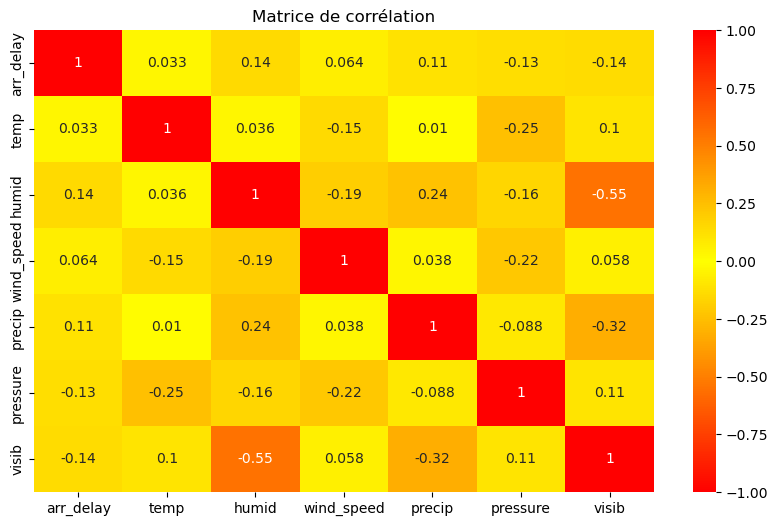

In [85]:
corr_matrix = merged_df[['arr_delay', 'temp', 'humid', 'wind_speed', 'precip', 'pressure', 'visib']].corr()
print(corr_matrix)

colors = ['red', 'yellow', 'red']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, norm=norm)
plt.title('Matrice de corrélation')
plt.show()

On calcule les corrélations entre les différentes variables météorologiques puis on affiche la matrice de corrélation. Pour que cette matrice soit plus lisible, on l'affiche ensuite sous forme de heatmap, plus la valeur sera proche de 0 (faible corrélation), plus la case sera proche du jaune et plus la valeur sera proche de -1 ou 1 (forte corrélation), plus la case sera rouge. On constate alors que les facteurs qui ont le plus d'influence sur les retards à l'arrivée sont l'humidité, la visibilité, la pression et les précipitations mais que leur influence reste limitée. On constate également que les facteurs humidité, précipitations et visibilité sont très liés, plus il y aura d'humidité, plus il y aura de précipitation, moins il y aura de visibilité et plus l'avion aura de risques d'arriver en retard. Quant à la pression, plus la pression sera faible, plus l'avion aura de risques d'arriver en retard.

            arr_delay      temp     humid  wind_speed    precip  pressure  \
arr_delay    1.000000  0.104838  0.148334    0.036688  0.086031 -0.124545   
temp         0.104838  1.000000  0.020859   -0.128615  0.020478 -0.283548   
humid        0.148334  0.020859  1.000000   -0.160551  0.264657 -0.200597   
wind_speed   0.036688 -0.128615 -0.160551    1.000000  0.041316 -0.192105   
precip       0.086031  0.020478  0.264657    0.041316  1.000000 -0.106009   
pressure    -0.124545 -0.283548 -0.200597   -0.192105 -0.106009  1.000000   
visib       -0.104173  0.145353 -0.574508    0.046944 -0.325202  0.107862   

               visib  
arr_delay  -0.104173  
temp        0.145353  
humid      -0.574508  
wind_speed  0.046944  
precip     -0.325202  
pressure    0.107862  
visib       1.000000  


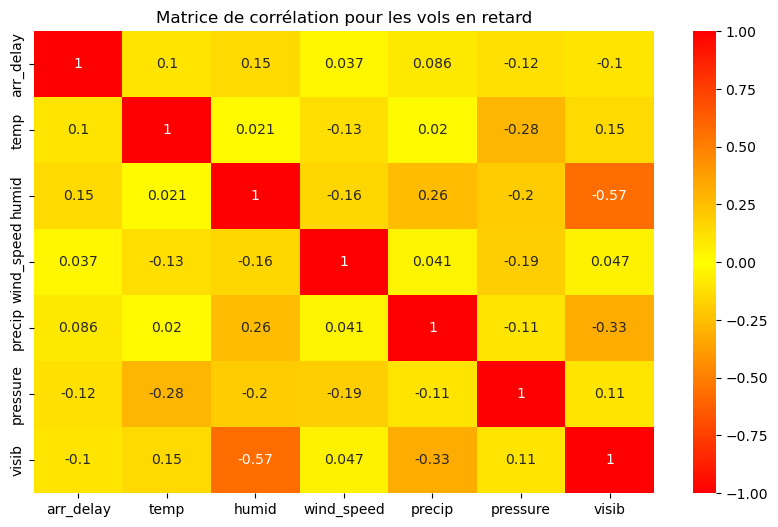

In [86]:
delayed_flights = merged_df[merged_df['arr_delay'] > 0]

corr_matrix_delayed = delayed_flights[['arr_delay', 'temp', 'humid', 'wind_speed', 'precip', 'pressure', 'visib']].corr()
print(corr_matrix_delayed)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_delayed, annot=True, cmap=custom_cmap, norm=norm)
plt.title('Matrice de corrélation pour les vols en retard')
plt.show()

On réalise la même matrice de corrélation que précédemment mais cette fois ci en prenant uniquement en compte les vols arrivés en retard. On remarque que cette matrice est assez ressemblante à la précédente même si l'on remarque que l'influence de la visibilité a plutot diminué alors que celle de la température a augmenté. Cependant, pour la température, cette méthode d'analyse n'est pas fiable car des températures extrêmes (très froides comme très chaudes) peuvent peut-être jouer sur les retards des avions et cela fausserait donc la matrice de corrélation. On va donc utiliser une autre méthode pour analyser l'influence de températures extrêmes sur les retards d'avions.

In [91]:
cold = 32 
hot = 86 

delayed_flights_copy = delayed_flights.copy()

delayed_flights_copy.loc[:, 'temp_category'] = pd.cut(
    delayed_flights['temp'],
    bins=[-float('inf'), cold, hot, float('inf')],
    labels=['Froid', 'Modéré', 'Chaud']
)

temp_category_stats = delayed_flights_copy.groupby('temp_category')['arr_delay'].describe()
print(temp_category_stats)

                  count  unique  top    freq
temp_category                               
Froid           13211.0   332.0  2.0   522.0
Modéré         114318.0   484.0  1.0  4390.0
Chaud            4693.0   309.0  1.0   139.0


/tmp/ipykernel_3363/3762446901.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_category_stats = delayed_flights_copy.groupby('temp_category')['arr_delay'].describe()


On définit tout d'abord des seuils de température froide et chaude (32°F et 86°F soit 0°C et 30°C). On définit ensuite 3 catégories de températures en s'aidant de ces seuils puis on "print" différentes statistiques pour chaque catégorie (nombre de données relevées, moyenne, écart-type, minimum, quartiles, maximum). On constate que des températures froides n'ont aucune influence sur les retards alors que des températures chaudes entraînent des retards plus importants.

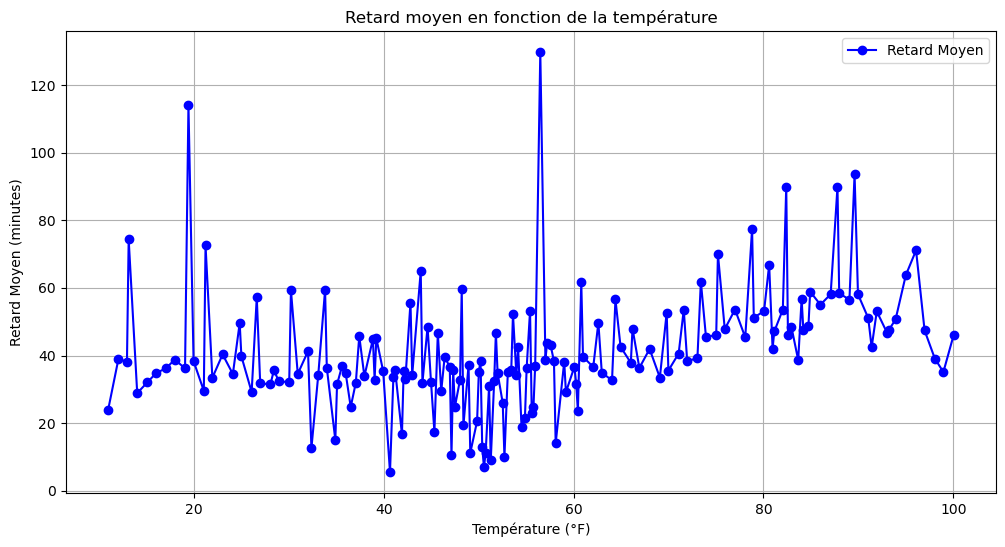

In [88]:
temperature_delay = delayed_flights.groupby('temp')['arr_delay'].mean()

plt.figure(figsize=(12, 6))
plt.plot(temperature_delay.index, temperature_delay.values, marker='o', color='b', label='Retard Moyen')

plt.title('Retard moyen en fonction de la température')
plt.xlabel('Température (°F)')
plt.ylabel('Retard Moyen (minutes)')
plt.legend()
plt.grid(True)
plt.show()

On regroupe les données de retard par température puis on trace la courbe du retard moyen en fonction de la température et on remarque la même chose que précédemment (hormis certaies valeurs très hautes qui peuvent être causées par le retard important d'un avion). Les températures froides n'ont aucun effet sur les retards alors que pour des températures chaudes (supérieures à 77°F soit 25°C) on remarque une légère augmenation des retards moyens.

In [90]:
delayed_flights.loc[:, 'wind_gust'] = delayed_flights['wind_gust'].astype(str)
delayed_flights.loc[:, 'arr_delay'] = delayed_flights['arr_delay'].astype(str)

delayed_flights.loc[:, 'wind_gust'] = delayed_flights['wind_gust'].str.replace(',', '.').astype(float)
delayed_flights.loc[:, 'arr_delay'] = delayed_flights['arr_delay'].str.replace(',', '.').astype(float)

cleaned_df = delayed_flights.dropna(subset=['wind_gust', 'arr_delay'])

corr = cleaned_df[['wind_gust', 'arr_delay']].corr()
print(corr)

           wind_gust  arr_delay
wind_gust   1.000000   0.026981
arr_delay   0.026981   1.000000


On convertit les deux colonnes en 'float' puis on supprime les lignes pours lesquelles nous n'avons pas d'informations sur les valeurs des rafales et on calcule ensuite la corrélation. On constate que cette corrélation est très faible, les rafales de vent n'ont donc sûrement pas de grande influence sur les retards d'avion ce qui vient confirmer le fait que le vent n'a pas de grande influence sur les retards d'avions comme constaté dans les deux premières matrices de corrélation.

En conclusion, on constate que les différents facteurs météorologiques ont presque tous (hormis le vent) une influence sur le retard des avions mais que cette influence reste assez limitée et que la cause principale de ces retards n'est donc sûrement pas un de ces facteurs météorologiques.